<a href="https://colab.research.google.com/github/fornitroll/Object-Detection-with-PyTorch-Kyiv-/blob/master/Lecture_3_Single_Shot_Detection_Yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 3. Single Shot Detection. Yolo (You only look once)

<img src="https://github.com/learnml-today/object-detection-with-pytorch/blob/master/imgs/yolo_v1_diagram.png?raw=true" >

So we already learned base concepts of object localization and in this lecture will use them to create a multi-object detection network. For our example, we will use [YoloV1 network](https://arxiv.org/abs/1506.02640) which is pretty old today, but it good breaking point between simple localization networks, and hard state-of-the-art multi-object detection networks. We work like this to build a strong intuition of how all these things work and how they've been developed, this will much help you especially when you will need to debug your solutions.

What we will learn in this lecture:

1. YoloV1 breakdown
2. New transformations and custom loss function
3. What to do if training stuck? How to debug your network?
4. Overview of changes in Yolo V2, V3.

In [0]:
import time
import os
import sys

import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFile
# fix bugs with loading png files
ImageFile.LOAD_TRUNCATED_IMAGES = True

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torch.hub import load_state_dict_from_url
from torchvision.ops.boxes import batched_nms


from google.colab import files
def upload(path):
    uploaded = files.upload()
    with open(path,'wb') as fp:
        fp.write(uploaded[list(uploaded.keys())[0]])
 
def download(path):
    files.download(path)

We will use our previous Dataset, to be able to train network fast. But I also include a version for VOC dataset (just in case)

In [0]:
!wget --quiet https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip PennFudanPed.zip

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotation/FudanPed00006.txt  
  inflating: PennFudanPed/Annotation/FudanPed00007.txt  
  inflating: PennFudanPed/Annotation/FudanPed00008.txt  
  inflating: PennFudanPed/Annotation/FudanPed00009.txt  
  inflating: PennFudanPed/Annotation/FudanPed00010.txt  
  inflating: PennFudanPed/Annotation/FudanPed00011.txt  
  inflating: PennFudanPed/Annotation/FudanPed00012.txt  
  inflating: PennFudanPed/Annotation/FudanPed00013.txt  
  inflating: PennFudanPed/Annotation/FudanPed00014.txt  
  inflating: PennFudanPed/Annotation/FudanPed00015.txt  
  i

## YoloV1

The architecture of the model divides the image into an S × S grid and each grid cell predicts B bounding boxes with confidence (fifth param),
and C class probability(same for all boxes in the cell). These predictions are encoded as an
**[ S, S, (B ∗ 5 + C) ]** matrix tensor. So each cell predicts one object of some class. 

<img src="https://github.com/learnml-today/object-detection-with-pytorch/blob/master/imgs/yolo_v1_diagram.png?raw=true" width="700">
</br>

**But why we need cells and many boxes for some object?**

*This answer on 2nd question in previous homework.* So we teach our model to predict the position of one object on the image. But what will happen if there will be 2 objects? - It will fail.

<img src="https://github.com/learnml-today/object-detection-with-pytorch/blob/master/imgs/cat2_1.png?raw=true"  width="700">

Basically, the network will try to predict the mean result to maximize the result. But that's will give us not what we want. **And that's a very important lesson: Network optimization finds simplest ways, but it not always lead to the result that we want. So wee need always keep this in our head when creating models.**

Ok, you can say that this is an obvious thing cause we prediction only one box location. Let's add one more.

<img src="https://github.com/learnml-today/object-detection-with-pytorch/blob/master/imgs/cat2_2.png?raw=true"  width="700">

As you can see result didn't change. That's because we add one more box, but we didn't say which box should detect which object, that's why their behavior didn't change. 

To handle this problem we need somehow to minimize the area of responsibility for each box, basically, transform our solution from global localization to local localization. And this is where breaking an image on cells can help us. So instead of many global detectors, we create many local detectors that responsible for their zone in the image. Thus detector of the Top Left corner will not pay attention to the object in the bottom right corner. The more cells we have the more accurate detection and simple training we should have (Theoretically. This is the second lesson. Not all good and logical ideas work in practice. Cause many small things can brake them).

The second problem is object shapes, the same as positions their shapes can be various and thus one box detector will handle badly such a situation. That's why we add a few of them, so each detector can specialize in one shape.

If talking mathematically, we doing normalization here with all these cells and boxes. While cells are doing mean normalization, boxes doing standard deviation normalization. And as we know when data is normalized NN can handle it much simpler.

And that's magic behind YoloV1 architecture(and other object detectors even if they do this in a slightly different manner like Fast-RCCN).
</br>

**Difference in coordinates markup**

When we were doing localization it was simpler to use x1,y1,x2,y2 coordinates. In Yolo, we use cx,cy,w,h, where cx,cy are relative to the top left corner of the grid cell and are the center of the object. That was made to simplify normalization and leave it in the interval [0,1] (In the next lecture I will be talking about SSD that has more difficult coordinates normalization technique)

**Grid size:** 2x2

<img src="https://github.com/learnml-today/object-detection-with-pytorch/blob/master/imgs/yolov1.png?raw=true" width="700">


In [0]:
# Here is how we can get VOC dataset. After downloading you will need to restart the notebook 
#(there are some bugs with Colab and it doesn't see downloaded dataset files)

# datasets.VOCDetection('./voc', download=True)

In [0]:
def encode_bbox(bbox, label, grid=7, boxes=2, classes=20):
    """
    Tranform input format boxes to the Yolo format

    :param bbox: [x1,y1,x2,y2] normalized coordinates in the top left and bottom right separately
    :param label: class labels
    :return: [xc, yc, w, h]
    """
    # element tensor will be looking like this
    # [xc1, yc1, w1, h1, confidense1,..,xcN, ycN, wN, hN, confidenseN class1,...,classM,..], N - number of boxes
    target = torch.zeros((grid, grid, boxes * 5 + classes))
    cell_size = 1./grid
    widths = bbox[:,2:]-bbox[:,:2]
    centers = (bbox[:,2:]+bbox[:,:2])/2
    for i in range(centers.shape[0]):
        # grid box index
        ij = np.ceil(centers[i]/cell_size)-1
        for b in range(boxes):
            # setting confidence
            target[int(ij[1]),int(ij[0]),4+b*5] = 1
        # setting label after boxes
        target[int(ij[1]),int(ij[0]),int(label[i])+(boxes)*5] = 1
        # match to the relative coordinates of the upper left corner of the grid
        xy = ij*cell_size
        delta_xy = (centers[i]-xy)/cell_size
        for b in range(boxes):
            # relative coords
            # The square root of the predicted boxes’ height and width are used 
            # as weights to penalize detections of both large and small objects. 
            target[int(ij[1]),int(ij[0]),2+b*5:4+b*5] = torch.as_tensor(np.sqrt(widths[i]))
            target[int(ij[1]),int(ij[0]),b*5:2+b*5] = torch.as_tensor(delta_xy)

    return target 

class LocTransformVoc:
    def __init__(self,size=(448,448),boxes=2,classes=20,grid=7,mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        self.size = size
        self.C = classes
        self.S = grid
        self.B = boxes
        # base transform for images
        self.img_ts = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(), # converts to [0,1] interval
            transforms.Normalize(mean=mean, std=std)
        ])        
        self.classes = [
            "person", "bird", "cat", "cow", "dog", "horse", "sheep",
            "aeroplane", "bicycle", "boat", "bus", "car", "motorbike", "train",
            "bottle", "chair", "diningtable", "pottedplant", "sofa", "tvmonitor"
        ] # 20 classes
        
    def box_resize(self, img_shape, box):
        """Method to resize bounding box"""
        w,h = img_shape
        xs,ys = self.size[0]/w, self.size[1]/h
        box = np.array([int(box['xmin'])*xs/self.size[0],int(box['ymin'])*ys/self.size[1],int(box['xmax'])*xs/self.size[0],int(box['ymax'])*ys/self.size[1]])
        return box
        
    def __call__(self, img, target=None):
        x = self.img_ts(img)
        if target:
            boxes = []
            labels = []
            # voc bboxes annotation can be list if many or dict if one (never do like this)
            objects = target['annotation']['object'] if isinstance(target['annotation']['object'], list) else [target['annotation']['object']]
            for bb in objects:
                boxes.append(self.box_resize(img.size,bb['bndbox']))
                labels.append(self.classes.index(bb['name']))
            out = encode_bbox(np.array(boxes),np.array(labels), grid=self.S, boxes=self.B, classes=self.C)
            return x,out
        return x

class PennFudanDataset(Dataset):
    def __init__(self, root, transforms=None):
        # path to the dataset
        self.root = root
        # transformation for image and targets
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        '''This method return one time(not batch), image and target'''
        
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        num_objs = len(obj_ids)
        targets = []
        # get bounding box coordinates for one mask other paint over
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            targets.append([xmin, ymin, xmax, ymax])
            
        if self.transforms is not None:
            img, targets = self.transforms(img, targets)

        return img, targets

    def __len__(self):
        '''this method return len of dataset'''
        return len(self.imgs)

class LocTransformPen:
    def __init__(self,size=(448,448),boxes=2,classes=1,grid=7,mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        self.size = size
        self.C = classes
        self.S = grid
        self.B = boxes
        # base transform for images
        self.img_ts = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(), # converts to [0,1] interval
            transforms.Normalize(mean=mean, std=std)
        ])        
        
    def box_resize(self, img_shape, box):
        """Method to resize bounding box"""
        w,h = img_shape
        xs,ys = self.size[0]/w, self.size[1]/h
        box = np.array([int(box[0])*xs/self.size[0],int(box[1])*ys/self.size[1],int(box[2])*xs/self.size[0],int(box[3])*ys/self.size[1]])
        return box 
        
    def __call__(self, img, target=None):
        x = self.img_ts(img)
        if target:
            labels = []
            boxes = []
            for bb in target:
                boxes.append(self.box_resize(img.size,bb))
                # we have only one class
                labels.append(0)
            out = encode_bbox(np.array(boxes),np.array(labels), grid=self.S, boxes=self.B, classes=self.C)
            return x,out
        return x

Don't forget to test our dataset and transformer

In [0]:
def test_dataloading(grid=2, size=448):
    # ds = datasets.VOCDetection('./voc', transforms=LocTransformVoc(grid=grid))
    ds = PennFudanDataset('./PennFudanPed', transforms=LocTransformPen(grid=grid))
    def denorm(x):
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        return (x * std) + mean

    for i in range(4):
        grid_size = size/grid
        img, ts = ds[i]
        img = (denorm(img.numpy().transpose(1,2,0).copy())*255).astype(np.uint8)

        for h, _ in enumerate(ts):
            for w, t in enumerate(ts[h]):
                t = t.numpy()
                for i in range(2):
                    _t = t[i*5:4+i*5]
                    x,y = grid_size*w,grid_size*h
                    xc,yc = x+_t[0]*grid_size,y+_t[1]*grid_size
                    _w,_h = size*_t[2]*_t[2],size*t[3]*t[3]
                    x1,y1 = int(xc - _w/2), int(yc - _h/2)
                    img = cv2.rectangle(img, (x1, y1), (int(x1 + _w), int(y1+_h)), (0, 255, 0), 2)
        plt.imshow(img)
        plt.show()
        print(img.shape)

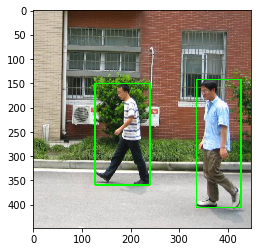

(448, 448, 3)


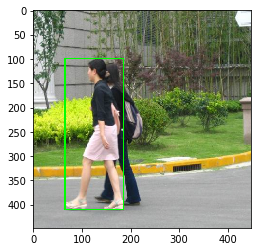

(448, 448, 3)


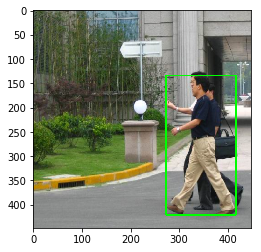

(448, 448, 3)


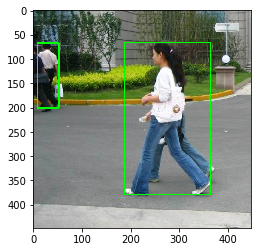

(448, 448, 3)


In [0]:
test_dataloading(grid=2)

Let's also see how many objects on one image in the dataset. That needed to understand how big the grid we need.

Also, it's good to test dataset on shapes distribution and object closeness (you can do it by yourself)

In [0]:
dd = PennFudanDataset('./PennFudanPed')
s = 0
for i in range(len(dd)):
    s += len(dd[i][1])
print('Mean objects on image:',s/len(dd))

Mean objects on image: 2.488235294117647


Originally YoloV1 trained in 2 steps: First one train model with classification head-on ImageNet Dataset, and then train it with detection head-on VOC dataset.

The first step will take 1 week, and as we don't wont to wait one week, we will use a pre-trained ResNet network as our base network(backbone network) and then just train detection head.

ResNet is using Relu activation, but it may be better to use LeakyRelu(0.1) instead if we are going to train with the backbone network. So I just copy part of the torchvision library and made small modifications. If you want to train only head, this step is not needed.

In [0]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.LeakyReLU(0.1, inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.LeakyReLU(0.1, inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.LeakyReLU(0.1, inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)

def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)

### YoloV1 architecture

In [0]:
class YoloV1(nn.Module):
    def __init__(self, freeze=True, classes=1, grid=4, boxes=2):
        super(YoloV1, self).__init__()
        self.classes = classes
        self.grid = grid
        self.boxes = boxes
        
        self.head =  nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.1),

            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
        )
        g = self.grid
        b = self.boxes
        self.relu = nn.LeakyReLU(0.1)
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(7*7*1024, 4096)
        self.fc2 = nn.Linear(4096, g*g*(b*5+classes))

        # initialize weights on Conv Layers for LeakyRelu activation
        # we do this before adding ResNet model to not reset weights of it.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            elif isinstance(m, nn.Sequential):
                for n in m.modules():
                    if isinstance(n, nn.Conv2d):
                        nn.init.kaiming_normal_(n.weight, mode='fan_out', nonlinearity='leaky_relu')

        _model = resnet18(pretrained=True) # using our modified verison with LeakyRelu
        if not freeze:
            # we freeze layer 1 as it contains distribution of low-level features that same among our datasets
            for name, parameter in _model.named_parameters():
                if 'layer2' not in name and 'layer3' not in name and 'layer4' not in name:
                    parameter.requires_grad_(False)
        else:
            _model.requires_grad_(False)

        self.base = nn.Sequential(*list(_model.children())[:-2])



    def forward(self, x):
        
        g = self.grid
        b = self.boxes
        batch = x.shape[0]
        x = self.base(x)
        x = self.head(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.relu(x)
        # Paper doesnt say about this, but on my experience is better to you use
        # dropout after some amount of iterations and loss stabilisation, in other case
        # it can take a while before get some good results.
        # Another thing is that dropout is not the best regularization because it too dumи.
        # For our training we dont need it cause it will make it longer.
        # x = self.drop(x)
        x = self.fc2(x)
        x = x.contiguous().view(-1, g, g, b*5+self.classes)
        # FIXED
        # sigmoid was removed from here, as we use it only for classes.
        # so we set it in loss and in inference function

        return x


In [0]:
x = torch.zeros((10, 3, 448, 448))
a = YoloV1(classes=1, grid=4, boxes=2)
print()
print(a(x).shape)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 27138936.72it/s]



torch.Size([10, 4, 4, 11])


### Building Loss function

Place where 99.99% of bugs happen

\begin{align}
Loss = &\lambda_{coord} \sum_{i=0}^{S^2}\sum_{j=0}^B \mathbb{1}_{ij}^{obj}[(x_i-\hat{x}_i)^2 + (y_i-\hat{y}_i)^2 ] &(loss\_xy)\\&+ \lambda_{coord} \sum_{i=0}^{S^2}\sum_{j=0}^B \mathbb{1}_{ij}^{obj}[(\sqrt{w_i}-\sqrt{\hat{w}_i})^2 +(\sqrt{h_i}-\sqrt{\hat{h}_i})^2 ]&(loss\_wh)\\
&+ \sum_{i=0}^{S^2}\sum_{j=0}^B \mathbb{1}_{ij}^{obj}(C_i - \hat{C}_i)^2 + \lambda_{noobj}\sum_{i=0}^{S^2}\sum_{j=0}^B \mathbb{1}_{ij}^{noobj}(C_i - \hat{C}_i)^2 &(loss\_obj)\\
&+ \sum_{i=0}^{S^2} \mathbb{1}_{i}^{obj}\sum_{c \in classes}(p_i(c) - \hat{p}_i(c))^2 &(loss\_class)\\
\end{align}

So here we have two coordinates losses: loss_xy,loss_wh, two confidence losses: loss_obj, and one class loss: loss_class.

${1}_{i}^{obj}$ - denotes if an object appears in cell i

${1}_{ij}^{obj}$ - denotes that the jth bounding box predictor in cell i is “responsible” for that prediction.

${1}_{ij}^{noobj}$ - denotes that the jth bounding box predictor in cell i should not have an object

$lambda_{coord}$ and $lambda_{noobj}$ - our modifiers that handle imbalance of cells that have object and cells which are empty.

Note that the loss function only penalizes classification
error if an object is present in that grid cell (hence the conditional class probability discussed earlier). It also only penalizes bounding box coordinate error if that predictor is
“responsible” for the ground truth box (i.e. has the highest
IOU of any predictor in that grid cell).

Also, you can see that we use square roots on width and height loss. Because our error metric should reflect those small deviations in large boxes matter less than in small
boxes. 

Sum-squared error used because of it easy to optimize (because it gives total value)


In [0]:
class Loss(nn.Module):
    def __init__(self, S=2, B=2, C=2, lambda_coord=5, lambda_noobj=0.5):
        super(Loss, self).__init__()
        self.S = S
        self.B = B
        self.C = C
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        
    def calc_iou(self, A, B):
        """
        Args:
            A (torch.FloatTensor): [N, SxSx(Bx5+C)]
            B (torch.FloatTensor): [N, SxSx(Bx5+C)]
        """

        A = A.view(-1, self.S, self.S, self.B * 5 + self.C)
        B = B.view(-1, self.S, self.S, self.B * 5 + self.C)
        
        A_x_center = A[:, :, :, 0:self.B*5:5]
        A_y_center = A[:, :, :, 1:self.B*5:5]
        A_w = A[:, :, :, 2:self.B*5:5]
        A_h = A[:, :, :, 3:self.B*5:5]
        
        B_x_center = B[:, :, :, 0:self.B*5:5]
        B_y_center = B[:, :, :, 1:self.B*5:5]
        B_w = B[:, :, :, 2:self.B*5:5]
        B_h = B[:, :, :, 3:self.B*5:5]
        
        A_area = A_w * A_h
        B_area = B_w * B_h

        inter_box_x0, _ = torch.max(torch.cat([(A_x_center-A_w/2).unsqueeze(dim=-1), (B_x_center-B_w/2).unsqueeze(dim=-1)], dim=-1), dim=-1)
        inter_box_y0, _ = torch.max(torch.cat([(A_y_center-A_h/2).unsqueeze(dim=-1), (B_y_center-B_h/2).unsqueeze(dim=-1)], dim=-1), dim=-1)

        inter_box_x1, _ = torch.min(torch.cat([(A_x_center+A_w/2).unsqueeze(dim=-1), (B_x_center+B_w/2).unsqueeze(dim=-1)], dim=-1), dim=-1)
        inter_box_y1, _ = torch.min(torch.cat([(A_y_center+A_h/2).unsqueeze(dim=-1), (B_y_center+B_h/2).unsqueeze(dim=-1)], dim=-1), dim=-1)
        
        inter_box_w = inter_box_x1-inter_box_x0
        inter_box_h = inter_box_y1-inter_box_y0

        inter = inter_box_w * inter_box_h * (inter_box_h>0).float() * (inter_box_w>0).float()

        iou = inter / (A_area + B_area - inter + 1e-6)

        return iou
        
    def get_argmax_iou(self, A, B):
        """
        Args:
            A (torch.FloatTensor): [N, SxSx(Bx5+C)]
            B (torch.FloatTensor): [N, SxSx(Bx5+C)]
        """

        iou = self.calc_iou(A, B)
        
        argmax = torch.argmax(iou, dim=-1)
        return argmax

    def forward(self, pred, target):
        """
        Args:
            pred (torch.floatTensor): [N, S, S, (Bx5+C)]
            target (torch.floatTensor): [N, S, S, Bx5+C] score is always equal to 1. bbox: [x_center, y_center, w, h]
        """
        device = torch.device('cuda' if pred.is_cuda else 'cpu')
        num_elements = self.B * 5 + self.C
        num_batch = target.size(0)
        
        target = target.view(-1, self.S*self.S, num_elements)
        pred = pred.view(-1, self.S*self.S, num_elements)
        # now target and pred: [N, SxS, (Bx5+C)]

        obj_mask = target[:,:,4] > 0
        noobj_mask = target[:,:,4] == 0

        obj_mask = obj_mask.unsqueeze(-1).expand_as(target).float()
        noobj_mask = noobj_mask.unsqueeze(-1).expand_as(target).float()
        # now obj_mask and noobj_mask: [N, SxS, (Bx5+C)]
        
        
        responsible_bbox_arg = self.get_argmax_iou(pred, target) # [N,S,S]
        # here we will get matrixs of tensors [0, 1, 2, 3, 4] for 1st box and 
        # tensors [k*0, k*1, k*2, k*3, k*4] where k = ((self.B-1)*5)
        responsible_bbox_scatter = torch.tensor((0, 1, 2, 3, 4))\
                                .repeat((num_batch, self.S * self.S, 1)).to(device)\
                                + responsible_bbox_arg.view(-1, self.S*self.S, 1)* ((self.B-1)*5) # [N,S*S, 5]

        responsible_bbox_mask = torch.zeros((num_batch, self.S * self.S, self.B * 5 + self.C)).to(device)\
                                .scatter_(2, responsible_bbox_scatter, torch.ones((num_batch, self.S * self.S, self.B * 5 + self.C)).to(device)) # [N,S*S, B*5]
        # this will result in matrix of tensors like this
        # [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.] which basicaly masking values of box with best IoU

        # multiply with out obj_mask to get only for existed objects
        responsible_bbox_mask = responsible_bbox_mask * obj_mask # [N,S*S, B*5]

        # class prediction loss
        class_prediction_loss = ((torch.sigmoid(pred) - torch.sigmoid(target)) * obj_mask)[:, :, self.B*5:].pow(2).sum()

        # no obj loss
        noobj_loss = self.lambda_noobj * ((torch.sigmoid(pred) - torch.sigmoid(target)) * noobj_mask)[:, :, 4:self.B*5:5].pow(2).sum()

        # obj loss
        obj_loss = ((torch.sigmoid(pred) - torch.sigmoid(target)) * responsible_bbox_mask)[:, :, 4:self.B*5:5].pow(2).sum()

        # coord loss
        coord_xy_loss = self.lambda_coord * ((pred-target) * responsible_bbox_mask)[:, :, 0:self.B*5:5].pow(2).sum()\
                        + self.lambda_coord * ((pred-target) * responsible_bbox_mask)[:, :, 1:self.B*5:5].pow(2).sum()

        coord_wh_loss = self.lambda_coord * ((pred-target) * responsible_bbox_mask)[:, :, 2:self.B*5:5].pow(2).sum()\
                        + self.lambda_coord * ((pred-target) * responsible_bbox_mask)[:, :, 3:self.B*5:5].pow(2).sum()
        
        total_loss = class_prediction_loss + noobj_loss + obj_loss + coord_xy_loss + coord_wh_loss
        metrics = {'class_loss':class_prediction_loss.cpu().detach().item(), 
                   'noobj_loss':noobj_loss.cpu().detach().item(), 
                   'obj_loss':obj_loss.cpu().detach().item(), 
                   'xy_loss':coord_xy_loss.cpu().detach().item(), 
                   'wh_loss':coord_wh_loss.cpu().detach().item()}
        return total_loss/num_batch, metrics


**!!!!** Read this loss definition carefully until you understand all transformation in it, cause it crucial thing to make model works properly. One small mistake and you will end up in weeks of pain

In [0]:
# training can take time more then Colab instance life so we can use small hack to save our weights in safe store
# we will use Google Drive for thhat
from google.colab import drive
# now your google drive on path ./drive
drive.mount('./drive')

Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).


In [0]:
torch.manual_seed(42)

grid = 4 # for 3 objects we dont need big grid
classes = 1
boxes = 2
path_save = './YoloV12.pth' # change to you drive path
path_load = None
# ds = datasets.VOCDetection('./voc', transforms=LocTransformVoc(grid=grid, classes=classes, boxes=boxes, size=(448,448)))
ds = PennFudanDataset('./PennFudanPed', transforms=LocTransformPen(grid=grid, classes=classes, boxes=boxes))

loader = DataLoader(ds, batch_size=4, pin_memory=True, drop_last=True) 
epochs = 200 # its enough to see good result

device = torch.device("cuda")
model =  YoloV1(True, classes=classes, grid=grid, boxes=boxes) 
if path_load:
    state = torch.load(path_load)
    model.load_state_dict(state)
model = model.to(device)
loss_f = Loss(S=grid,C=classes,B=boxes, lambda_noobj=0.6) # slightly increase noobj coef

# On this dataset Adam can converge much faster then SGD
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=5e-4)
# for L2 regularization you can add weight_decay=5e-4, as in paper
# optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)

st = time.time()
model.train()
for e in range(epochs):
    t = 0
    loss_avg = 0
    iou_avg = 0
    for i, (img, target) in enumerate(loader):
        img = img.to(device)
        target = target.to(device)
        
        # before each iteration we clear all gradients calculated before 
        optimizer.zero_grad()
        output = model(img)
        loss, m = loss_f(output, target)
        # calculating gradients
        loss.backward()
        # optimizing
        optimizer.step()
        # .item() is simple way to get value from scalar
        loss_avg += loss.item()
        t += 1
    print(f'Epoch: {e}/{epochs} Loss:{loss_avg/t}, LR:{optimizer}')
    print(m)
    try:
        torch.save(model.state_dict(), path_save)
    except KeyboardInterrupt as e:
        print('SAVING !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        torch.save(model.state_dict(), path_save)
        raise e

    scheduler.step(loss_avg/t)
    t = 0
    loss_avg = 0
    
print('Training time:', time.time()-st)

Epoch: 0/200 Loss:0.004005922628234008, LR:Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0.0005
)
{'class_loss': 4.2411498725414276e-05, 'noobj_loss': 0.0036033738870173693, 'obj_loss': 0.0026931369211524725, 'xy_loss': 0.0024621065240353346, 'wh_loss': 0.0011372528970241547}
Epoch: 1/200 Loss:0.01776208256792632, LR:Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0.0005
)
{'class_loss': 4.076826007803902e-05, 'noobj_loss': 0.004589263815432787, 'obj_loss': 0.0024345458950847387, 'xy_loss': 0.01027387659996748, 'wh_loss': 0.0049654762260615826}
Epoch: 2/200 Loss:0.01484532664263887, LR:Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0.0005
)
{'class_loss': 4.6920722525101155e-05, 'noobj_loss': 0.005058989394456148, 'obj_loss': 0.0025025028735399246, 'xy_loss': 0.010861784219741821, 'wh_

KeyboardInterrupt: ignored

### Non-Maximum Suppression (NMS)

if we visualize our model output, because of many detectors, we will get many boxes like this:

<img src="https://github.com/learnml-today/object-detection-with-pytorch/blob/master/imgs/nonms.png?raw=true">

But we need only two boxes for two objects, so we need to minimize their number, and that's where NMS will help us to get such result:

<img src="https://github.com/learnml-today/object-detection-with-pytorch/blob/master/imgs/withnms.png?raw=true">

Briefly, it works like this:
1. Remove all boxes with confidence less than threshold1
2. Pick boxes with the largest confidence
3. Remove all boxes that IoU with the boxes from step 2 is bigger then threshold2

The main problem with it that we need to calculate it fast, very fast, and even faster to not add overhead to our model. Thanks, Odin, PyTorch has this algorithm implemented in C. 

In [0]:
# we use batches_nms cause we can have many classes of different objects
from torchvision.ops.boxes import batched_nms

def test(model_path, model_class, input, num=6, boxes=2, thresh=0.5, size=448, grid=4, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    classes = [
        "person", "bird", "cat", "cow", "dog", "horse", "sheep",
        "aeroplane", "bicycle", "boat", "bus", "car", "motorbike", "train",
        "bottle", "chair", "diningtable", "pottedplant", "sofa", "tvmonitor"
    ]

    def denorm(x):
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        return (x * std) + mean

    state = torch.load(model_path)
    model = model_class.cpu()
    model.load_state_dict(state)
    model.eval()
    img_ts = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(), # converts to [0,1] interval
        transforms.Normalize(mean=mean, std=std)
    ])  
    total = 0
    iou_avg = 0
    if isinstance(input, Image.Image):
        input = [[img_ts(input), None]]
    for img, target in input:
        img = img.view((1,)+img.shape)
        st = time.time()
        res = model(img)
        res = res[0].detach().cpu()
        print('Inference time:', time.time()-st)
        st = time.time()
        sz = 1./grid
        
        labels = torch.sigmoid(res[:,:,boxes*5:].repeat((1,1,boxes)).view(-1,1))
        scores, labels = torch.max(labels,dim=-1)
        # transforming our xc,yc,w,h back to x1,y1,x2,y2
        cc = res[:,:,:boxes*5].view(grid,grid,boxes,5)
        xx = torch.arange(0.,1.,sz).view(1,grid,1).repeat((grid,1,boxes))
        yy = torch.arange(0.,1.,sz).view(grid,1,1).repeat((1,grid,boxes))
        cc[:,:,:,0] = cc[:,:,:,0]*sz + xx - np.square(cc[:,:,:,2])/2
        cc[:,:,:,1] = cc[:,:,:,1]*sz + yy - np.square(cc[:,:,:,3])/2
        cc[:,:,:,2] = cc[:,:,:,0] + np.square(cc[:,:,:,2])
        cc[:,:,:,3] = cc[:,:,:,1] + np.square(cc[:,:,:,3])

        bboxes = cc.contiguous().view(-1,5)
        print(scores.shape, bboxes.shape)
        
        # adding confidence threshold
        scores = scores.view(-1)[(bboxes[:,4] >= thresh)]
        labels = labels.view(-1)[(bboxes[:,4] >= thresh)]
        bboxes = bboxes[(bboxes[:,4] >= thresh)][:,:4]

        print('Mod time:', time.time()-st)
        st = time.time()
        idx = batched_nms(bboxes, scores, labels, iou_threshold=0.5).numpy().astype(np.uint64)
        print('NMS time:', time.time()-st)
        labels = labels.numpy().astype(np.uint8)
        scores = scores.numpy()
        bboxes = bboxes.numpy()

        img = (denorm(img[0].numpy().transpose(1,2,0).copy())*255).astype(np.uint8)
        for i in idx:
            b = bboxes[i] 
            img = cv2.rectangle(img, (int(b[0]*size), int(b[1]*size)), (int(b[2]*size), int(b[3]*size)), (0, 255, 0), 2)
            print(int(b[0]*size), int(b[1]*size), int(b[2]*size), int(b[3]*size), classes[labels[i]], scores[i])
                        
        
        plt.imshow(img)
        plt.show()

        total += 1
        if total >= num:
            break

Inference time: 0.5835123062133789
torch.Size([32]) torch.Size([32, 5])
Mod time: 0.0018095970153808594
NMS time: 0.0006432533264160156
304 88 413 431 person 0.99149245
107 108 201 407 person 0.9907353
130 135 244 371 person 0.9907353


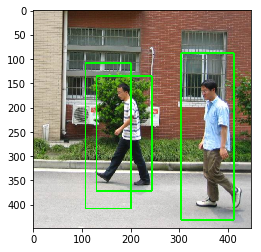

Inference time: 0.6243128776550293
torch.Size([32]) torch.Size([32, 5])
Mod time: 0.0011229515075683594
NMS time: 0.00031113624572753906
64 81 189 421 person 0.9971607
126 72 224 413 person 0.9971607


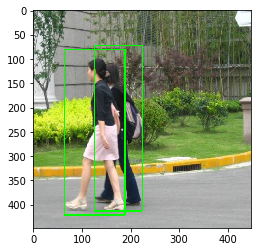

Inference time: 0.6015219688415527
torch.Size([32]) torch.Size([32, 5])
Mod time: 0.0017077922821044922
NMS time: 0.0004200935363769531
268 127 416 432 person 0.9934462
332 137 422 414 person 0.9934462


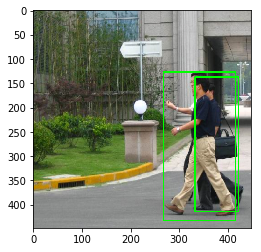

Inference time: 0.6212232112884521
torch.Size([32]) torch.Size([32, 5])
Mod time: 0.001322031021118164
NMS time: 0.0002770423889160156
192 57 363 389 person 0.9833029
7 64 52 205 person 0.97893035


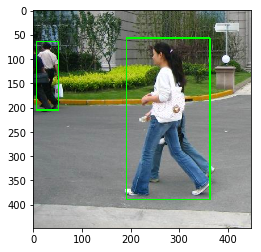

Inference time: 0.5914745330810547
torch.Size([32]) torch.Size([32, 5])
Mod time: 0.001230478286743164
NMS time: 0.00029206275939941406
247 73 428 438 person 0.99189997
2 62 46 204 person 0.98645407


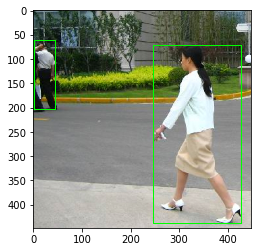

Inference time: 0.6063833236694336
torch.Size([32]) torch.Size([32, 5])
Mod time: 0.0017216205596923828
NMS time: 0.00041866302490234375
223 138 302 389 person 0.9954692
244 89 409 410 person 0.9954692
46 93 131 410 person 0.9938133
1 91 99 416 person 0.9938133


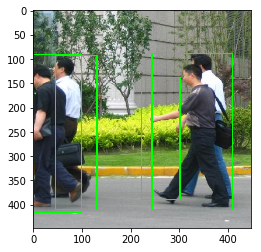

In [0]:
# dd = datasets.VOCDetection('./voc', transforms=LocTransform(grid=7, size=(448,448)))
dd = PennFudanDataset('./PennFudanPed', transforms=LocTransformPen(grid=grid, classes=classes))
test(path, YoloV1(True, classes=classes, boxes=boxes, grid=grid), dd, size=448, grid=grid)

You may see that it detects more people that were marked in the dataset, and that's a cool thing. Because it gives you the ability to increase the quality of the dataset by re-label it with a network trained on it.

Such a hack can increase the quality of training and give you a better quality dataset that u can use in the future.

## What to do if training stuck? How to debug your network?

Some of the problems are covered in my old [article on Medium](https://medium.com/machine-learning-world/how-to-debug-neural-networks-manual-dc2a200f10f2)

But in most cases there are a few simple rules that can help you:

* Start from simple solution and after it works to add additional modifications
* Overfit on a small dataset to see if model architecture really works
* If you use compound loss always print out partial losses to see where is problem
* If the result is same for different outputs in most cases your model weights are dead, check them, and always check them, they shouldn't be zero (aka 1.00e-22)
* Adam optimizer making big jumps and good on start while SGD better works on finish steps
* Look at your loss and control your learning rate. Lower it if loss goes up and down, or if it fixed near some value.
* Use regularisation after all things are tested and worked.
* When writing complicated code always add tests to it. You don't want to train a model for 2 weeks and then understand that some index in loss function is wrong.

## Overview of the next versions of Yolo

### Yolo V2
**Anchor boxes**
While in the YoloV1 our boxes competitive with each other. In the newer version, they were replaced with anchor boxes, which is basically boxes with predefined shape. This shape can be set by hands or can be predicted with a clusterization algorithm like k-Means.

**Removed fully-connected layers**
These layers were replaced by 1x1 Convolution(which is channel reduction operation)

**Multi-scale training**
YoloV2 were trained with random images with different dimensions range between 320x320 to 608x608

**Fine-Grained Features** Feature extractor now return 13x13 grid instead of 7x7

**Batch Normalization added**

### Yolo V3
**Feature Pyramid** Making a prediction based on 3 scales from network

**Much-Deeper network** Darknet-53 instead of Darnet-19. Max-Pooling removed

**Multi-Lable classification** Softmax was replaced by regressors for each class, thus one object can have few labels.

**Bounding Box Predictions** Gives the score for the objects for each bounding box. It uses logistic regression to predict the objectiveness score.

# Summary and homework

That's was a little harder than the previous lecture, but I'm happy that we made this. Congratulations!</br>Now you can use this experience to solve real-world tasks.

## Homework

1. Investigate code difference between YoloV1 and YoloV2. Try to find YoloV2 solutions on Github, but check it by papers (in most of them there are plenty of bugs)
2. Investigate the VOC dataset by calculating mean objects per image, min/max/mean closeness of objects on image, shape distribution by class.
3. Try to run YoloV1 on the VOC dataset with the ResNet50 base network. And don't forget to set new params for Yolo network.

Questions can be asked here: https://github.com/learnml-today/object-detection-with-pytorch
